# cyTOF longitudinal data analysis

Data has 60 cell types; 9 samples

In [1]:
import numpy as np
import arviz as az
import seaborn as sns
import pandas as pd
import pickle as pkl
import importlib
import anndata as ad

import matplotlib.pyplot as plt
import os
import sys

sys.path.append("C:/Users/Johannes/Documents/Uni/Master's_Thesis/compositionalDiff-johannes_tests_2")

import util.result_classes as res
import util.comp_ana as mod
import util.compositional_analysis_generation_toolbox as gen
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Import data

celltypes_path = "C:/Users/Johannes/Documents/Uni/Master's_Thesis/data/20200112_SLE_FreqTable.csv"

celltypes = pd.read_csv(celltypes_path, sep=";", header=[0], index_col=[0])


C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\anndata\_core\anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


### Data preparation

Get cell counts and round them

Build anndata object

In [2]:
# Groups

group_df = pd.DataFrame(celltypes["Group"])
group_df["int_Group"] = [0, 0, 0, 0, 0, 1, 1, 1, 1]
print(group_df)

# Get cell counts (rounded???)

cell_freq = celltypes.iloc[:, 3:]
cell_counts_df = cell_freq.multiply(celltypes["Unfiltered|count_CD45"], axis=0).round(0)
cell_counts = cell_counts_df.values

# Get names of celltypes

cluster_names = np.arange(60)+1
print(cluster_names)

cell_types = pd.DataFrame(index=cluster_names)
print(cell_types)

Transforming to str index.


                       Group  int_Group
file                                   
SLErun_Tube1_CD45.fcs    SLE          0
SLErun_Tube2_CD45.fcs    SLE          0
SLErun_Tube3_CD45.fcs    SLE          0
SLErun_Tube4_CD45.fcs    SLE          0
SLErun_Tube5_CD45.fcs    SLE          0
SLErun_Tube7_CD45.fcs     ND          1
SLErun_Tube8_CD45.fcs     ND          1
SLErun_Tube9_CD45.fcs     ND          1
SLErun_Tube10_CD45.fcs    ND          1
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]


sle_freq_data = ad.AnnData(X=cell_counts, var=cell_types, obs=group_df)

In [3]:
### Modeling without baseline


MCMC sampling finished. (128.306 sec)
Acceptance rate: 80.6%
get_y_hat (9.726 sec)
converted posterior (399.752 sec)
Compositional Analysis summary:
Intercepts:
           Final Parameter  HPD 2.5%  HPD 97.5%     SD  Expected Sample
Cell Type                                                              
1                    1.013     1.003      1.026  0.007      2847.602454
2                    0.265     0.255      0.279  0.006      1347.805071
3                    0.248     0.230      0.259  0.008      1325.086044
4                   -0.596    -0.607     -0.586  0.006       569.769946
5                   -0.005    -0.018      0.009  0.008      1028.886754
6                   -1.167    -1.186     -1.150  0.010       321.897340
7                   -0.110    -0.136     -0.075  0.019       926.331975
8                    1.184     1.161      1.200  0.010      3378.653969
9                   -0.384    -0.412     -0.364  0.013       704.319913
10                   0.029     0.012      0.053


ana = mod.CompositionalAnalysis(sle_freq_data, "Group", baseline_index=None)
ca_result = ana.sample_hmc(num_results=int(20000), n_burnin=5000)

ca_result.summary(hdi_prob=0.95)

(9, 17)


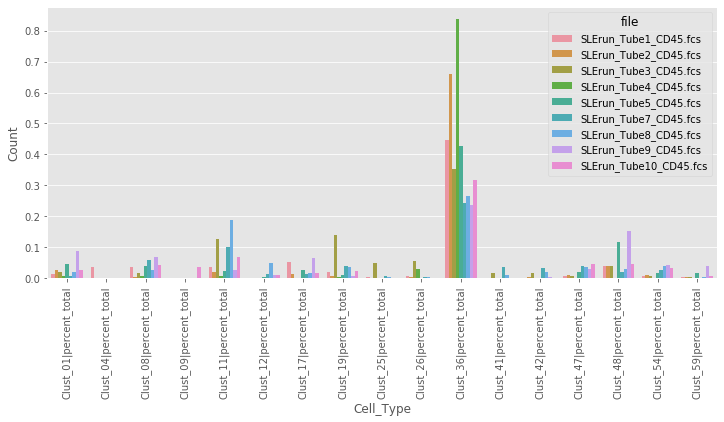

In [9]:
This does not work well (too many cell types)! -> all inclusion_probs are 0 or 1

Lowering number of cell types by excluding underrepresented ones...

### Use only celltypes with more than 3% of total cells in at least one sample (17 types)


cells_rep = cell_counts_df.loc[:, ~(cell_freq < 0.03).all()]
cells_rep_rel = cell_freq.loc[:, ~(cell_freq < 0.03).all()]
cell_types_rep = pd.DataFrame(index=cells_rep.columns)

sle_freq_data = ad.AnnData(X=cells_rep.values, var=cell_types_rep, obs=group_df)
print(sle_freq_data.X.shape)

In [9]:
cells_plot = pd.melt(cells_rep_rel.reset_index(), id_vars="file", var_name="Cell_Type", value_name="Count")

cells_plot_2 = pd.melt(cells_rep_rel.drop(columns="Clust_36|percent_total").reset_index(), id_vars="file", var_name="Cell_Type", value_name="Count")

fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=cells_plot, x="Cell_Type", y="Count", hue="file", ax=ax)
plt.xticks(rotation=90)
plt.show()

                        Clust_48|percent_total  Clust_54|percent_total  \
file                                                                     
SLErun_Tube1_CD45.fcs                   6814.0                  1506.0   
SLErun_Tube2_CD45.fcs                   3196.0                   885.0   
SLErun_Tube3_CD45.fcs                   1394.0                   234.0   
SLErun_Tube4_CD45.fcs                     87.0                    52.0   
SLErun_Tube5_CD45.fcs                   5421.0                   832.0   
SLErun_Tube7_CD45.fcs                   4267.0                  5934.0   
SLErun_Tube8_CD45.fcs                   3506.0                  4550.0   
SLErun_Tube9_CD45.fcs                  24174.0                  6891.0   
SLErun_Tube10_CD45.fcs                  8250.0                  6024.0   

                        Clust_59|percent_total  
file                                            
SLErun_Tube1_CD45.fcs                    941.0  
SLErun_Tube2_CD45.fcs                 

### Modeling without baseline


In [ ]:
ana = mod.CompositionalAnalysis(sle_freq_data, "int_Group", baseline_index=None)

# Still bad convergence -> increase chain length
ca_result = ana.sample_hmc(num_results=int(100000), n_burnin=5000)

ca_result.summary(hdi_prob=0.95)

### With baseline

Baseline on celltype clust_26 (index 9)

ana_bl_reduced = mod.CompositionalAnalysis(sle_freq_data, "int_Group", baseline_index=9)

# Still bad convergence -> increase chain length
result_bl_reduced = ana_bl_reduced.sample_hmc(num_results=int(100000), n_burnin=5000)

result_bl_reduced.summary(hdi_prob=0.95)

In [5]:
Not a good idea from relative point of view (see plot)

MCMC sampling finished. (625.021 sec)
Acceptance rate: 79.8%
converted posterior (458.595 sec)
Compositional Analysis summary:
Intercepts:
                        Final Parameter  HPD 2.5%  HPD 97.5%     SD  \
Cell Type                                                             
Clust_01|percent_total            0.198    -0.357      0.799  0.367   
Clust_04|percent_total           -1.394    -1.825     -0.862  0.263   
Clust_08|percent_total            0.446     0.049      0.792  0.192   
Clust_09|percent_total           -1.020    -1.519     -0.615  0.242   
Clust_11|percent_total            0.568     0.200      0.935  0.190   
Clust_12|percent_total           -0.952    -1.550     -0.140  0.354   
Clust_17|percent_total           -0.064    -0.461      0.427  0.238   
Clust_19|percent_total           -0.280    -0.609      0.118  0.201   
Clust_25|percent_total           -0.500    -0.979     -0.172  0.195   
Clust_26|percent_total           -0.473    -1.174      0.107  0.372   
Clust_36|

Baseline on celltype clust_04 (index 1)

In [6]:
ana_bl_reduced = mod.CompositionalAnalysis(sle_freq_data, "int_Group", baseline_index=1)

# Still bad convergence -> increase chain length
result_bl_reduced = ana_bl_reduced.sample_hmc(num_results=int(100000), n_burnin=5000)

result_bl_reduced.summary(hdi_prob=0.95)

MCMC sampling finished. (596.868 sec)
Acceptance rate: 79.5%
converted posterior (452.900 sec)
Compositional Analysis summary:
Intercepts:
                        Final Parameter  HPD 2.5%  HPD 97.5%     SD  \
Cell Type                                                             
Clust_01|percent_total            0.058    -0.492      0.573  0.303   
Clust_04|percent_total           -1.224    -1.761     -0.806  0.257   
Clust_08|percent_total            0.378    -0.193      0.909  0.277   
Clust_09|percent_total           -1.076    -1.688     -0.536  0.292   
Clust_11|percent_total            0.505     0.051      0.929  0.226   
Clust_12|percent_total           -1.022    -1.668     -0.399  0.346   
Clust_17|percent_total           -0.155    -0.569      0.366  0.225   
Clust_19|percent_total            0.141    -0.221      0.554  0.205   
Clust_25|percent_total           -1.018    -1.782     -0.461  0.324   
Clust_26|percent_total           -0.647    -1.309     -0.049  0.356   
Clust_36|

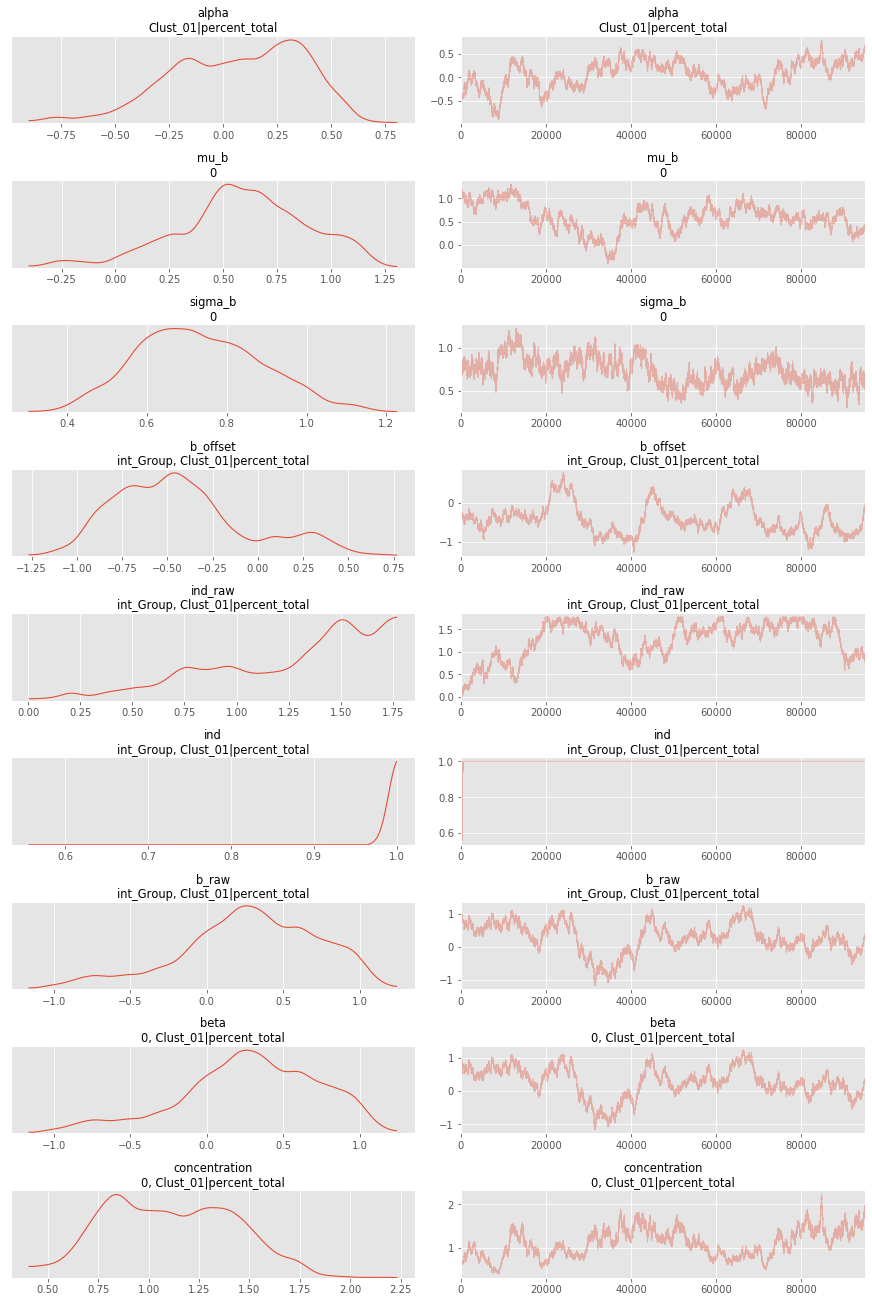

In [7]:
Baseline on celltype clust_09 (index 3)